In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from models import Models
from morph import Morph
from generation import Generation

## Shift and Percentage Borderline Pairs Loop


In [ ]:
shift_values = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.0]

final = {}
for b in [0.05, 0.10, 0.15, 0.20, 0.25]:
    results = {}
    for s in shift_values:
        # Generate dataset with shift
        gen = Generation(base_functions=('sin', 'sin'), n_samples=100, frequencies=(0.5,0.5), noise_level=(0.05, 0.05), shift_vert=s, shif_horz=s) 
        X, y = gen.generate_data()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train models
        lstm = Models('lstm', X_train, y_train)
        lstm.train_lstm()
        catch22 = Models('catch22', X_train, y_train)
        catch22.train_catch22()
        rocket = Models('rocket', X_train, y_train)
        rocket.train_rocket()

        # Calculate morphing
        res = {}
        morph = Morph(X_test, y_test)
        morph.get_DTWGlobalBorderline(perc_samples=b) 

        res['lsmt'] = morph.Binay_MorphingCalculater(lstm)
        res['catch22'] = morph.Binay_MorphingCalculater(catch22)
        res['rocket'] = morph.Binay_MorphingCalculater(rocket)

        results[s] = res
    final[b] = results

In [ ]:
with open('results/bord_perc_shift_perf.pkl', 'wb') as f:
    pickle.dump(final, f)

In [ ]:
columns = ['border_perc', 'shift_val', 'model', 'mean', 'std']

data = []
for border_perc in final.keys():
    for shift_val in final[border_perc].keys():
        for model in final[border_perc][shift_val].keys():
            line = [border_perc, shift_val, model, final[border_perc][shift_val][model][3]['mean'], final[border_perc][shift_val][model][3]['std']]
            data.append(line)

# save to csv
df = pd.DataFrame(data, columns=columns)
df.to_csv('results/bord_perc_shift_perf.csv', index=False)

In [ ]:
df = pd.read_csv('results/bord_perc_shift_perf.csv')
df.head() 

,border_perc,shift_val,model,mean,std
0,0.05,0.50,lsmt,0.585,0.005000
1,0.05,0.50,catch22,0.450,0.046904
2,0.05,0.50,rocket,0.475,0.008660
3,0.05,0.45,lsmt,0.524,0.010198
4,0.05,0.45,catch22,0.366,0.019596


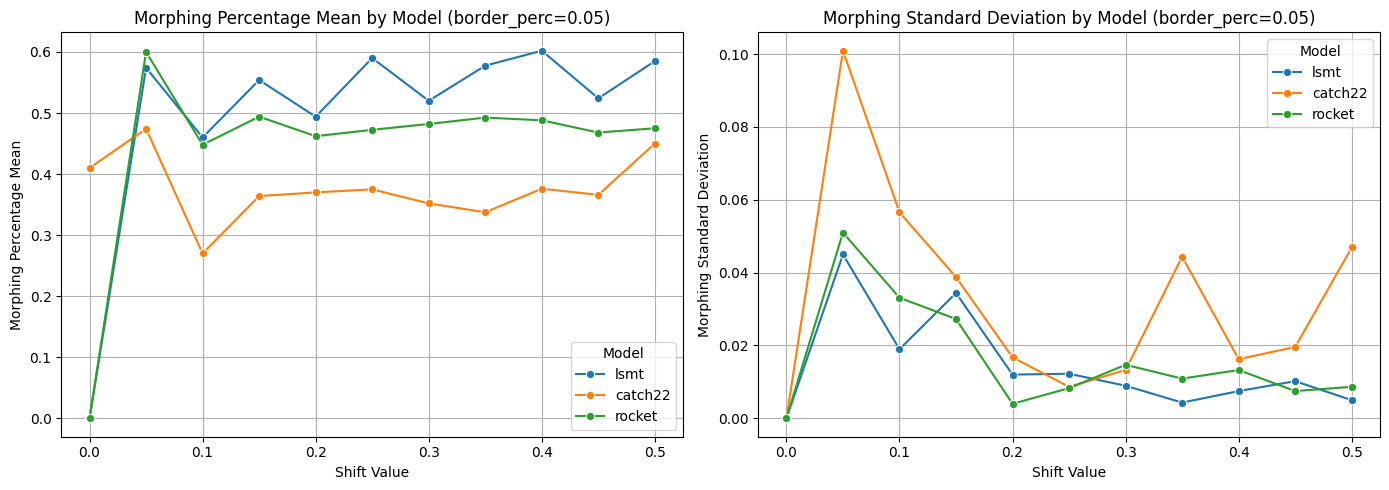

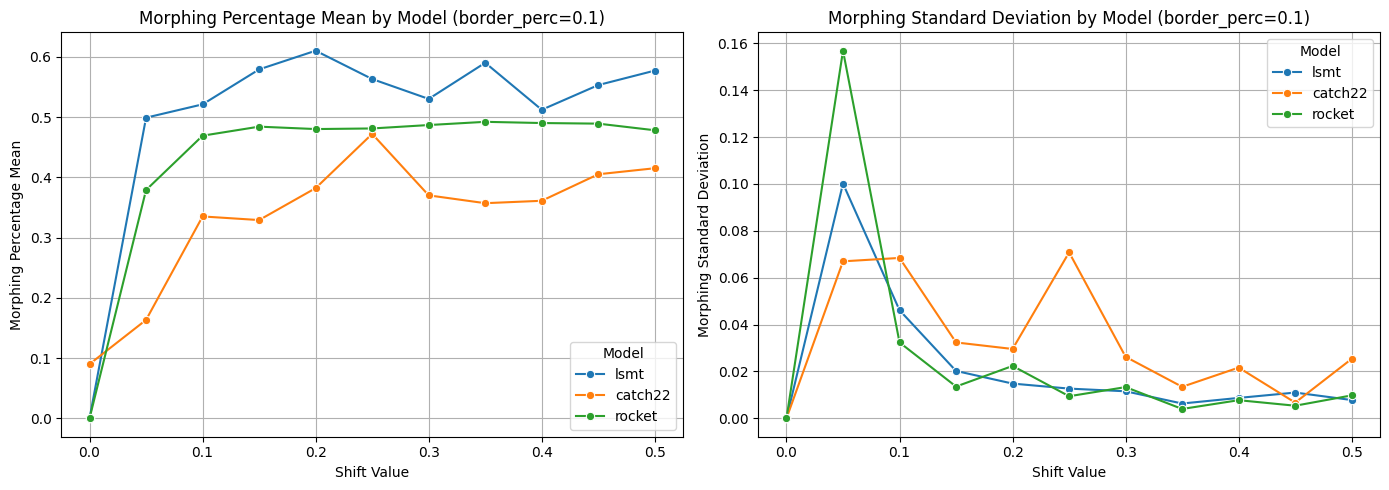

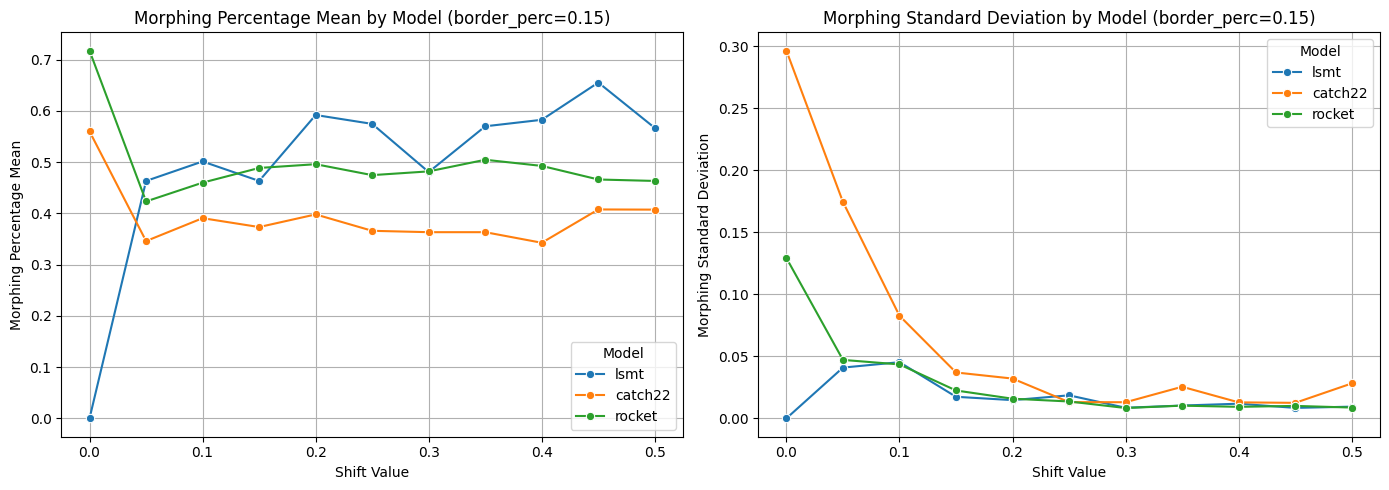

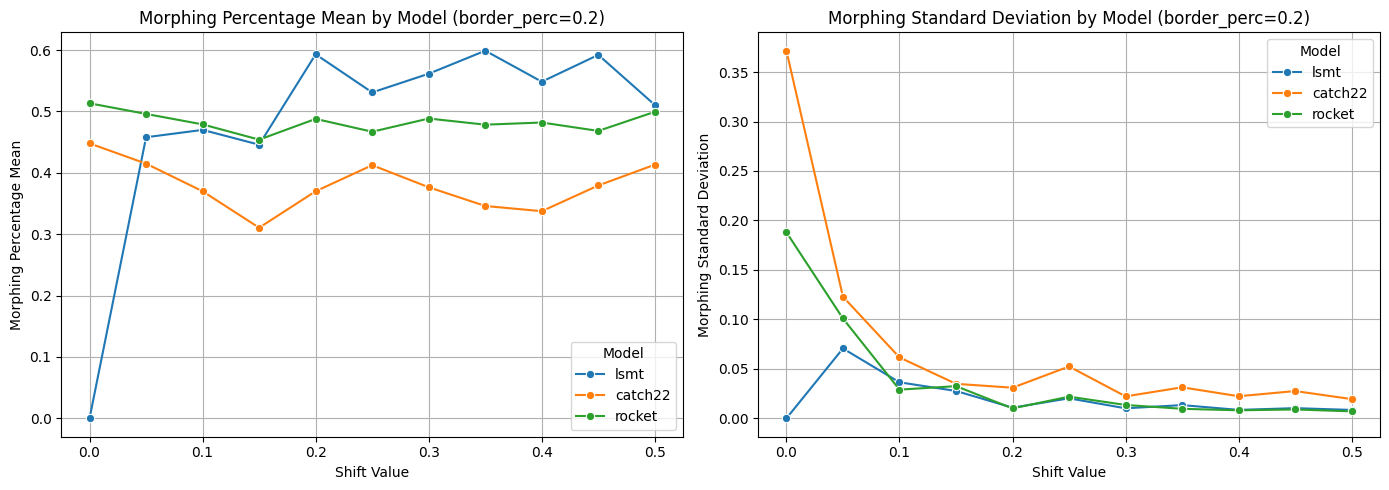

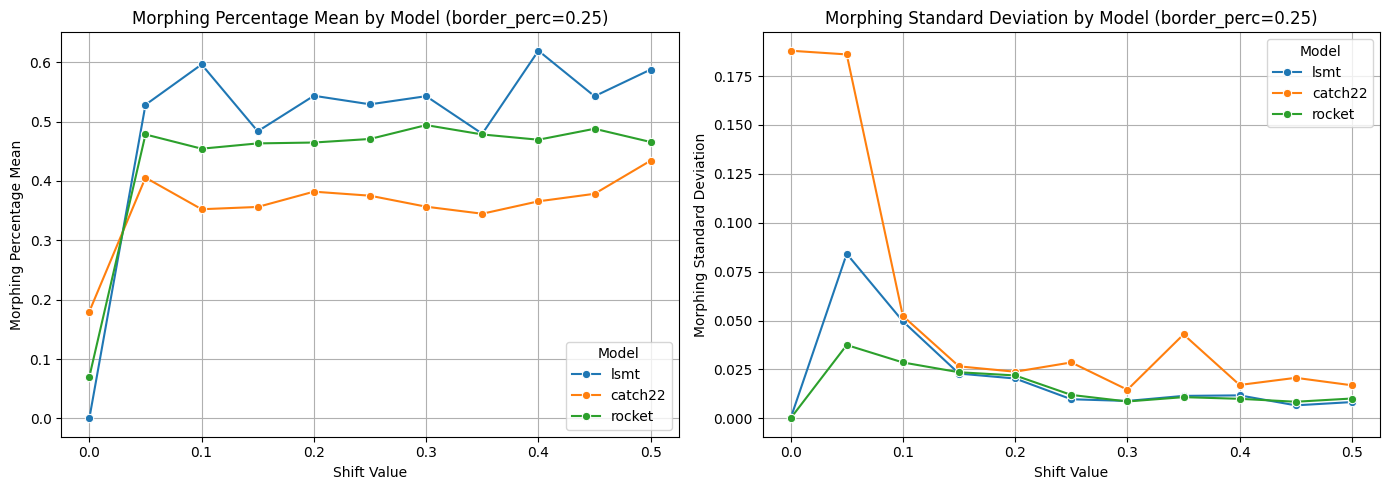

In [ ]:
# Get unique border_perc values
border_perc_values = df["border_perc"].unique()

# Create plots for each border_perc level
for border_perc in border_perc_values:
    subset = df[df["border_perc"] == border_perc]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Mean Morphing Percentage
    sns.lineplot(
        data=subset, x="shift_val", y="mean", hue="model", marker="o", ax=axes[0]
    )
    axes[0].set_title(f"Morphing Percentage Mean by Model (border_perc={border_perc})")
    axes[0].set_xlabel("Shift Value")
    axes[0].set_ylabel("Morphing Percentage Mean")
    axes[0].legend(title="Model")
    axes[0].grid(True)

    # Plot Standard Deviation
    sns.lineplot(
        data=subset, x="shift_val", y="std", hue="model", marker="o", ax=axes[1]
    )
    axes[1].set_title(
        f"Morphing Standard Deviation by Model (border_perc={border_perc})"
    )
    axes[1].set_xlabel("Shift Value")
    axes[1].set_ylabel("Morphing Standard Deviation")
    axes[1].legend(title="Model")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show() 

## Distance to Class Boundary

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from aeon.datasets import load_classification

X, y = load_classification("ECG200")

y = np.where(y == '-1', 0, y)
y = y.astype(np.float64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [3]:
#gen = Generation(base_functions=('sin', 'sin'), n_samples=100, frequencies=(0.5,0.5), noise_level=(0.05, 0.05), shift_vert=0.2, shif_horz=0.2)
#X, y = gen.generate_data()
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rocket = Models('rocket', X_train, y_train)
rocket.train_rocket()
morph = Morph(X_test, y_test, target_class=1)
morph.get_DTWGlobalBorderline(perc_samples=0.2)

res = morph.Binay_MorphingCalculater(rocket)

In [7]:
res[2]

{(4, 5): 0.68,
 (2, 17): 0.47,
 (2, 31): 0.56,
 (6, 14): 0.71,
 (2, 18): 0.53,
 (2, 8): 0.62,
 (2, 14): 0.61,
 (2, 13): 0.44,
 (4, 14): 0.66,
 (4, 17): 0.57,
 (0, 17): 0.77,
 (2, 1): 0.55,
 (6, 17): 0.6,
 (2, 20): 0.66,
 (7, 7): 0.5,
 (5, 19): 0.62,
 (0, 14): 0.68,
 (1, 5): 0.77,
 (6, 5): 0.73,
 (2, 27): 0.47,
 (6, 31): 0.65,
 (2, 6): 0.61,
 (0, 20): 0.81,
 (2, 26): 0.4,
 (2, 5): 0.63}

In [ ]:
# return morphs, preds, results, metrics
# self.borderline_pair

source = []
target = []
for p in morph.borderline_pairs.keys(): # Dict {(x,y):distance}
    source.append(p[0])
    target.append(p[1])

source = set(source)
target = set(target)
print(source)
print(target)

-
mean_morph = {}
for s in source:
    morphs = []
    for p in morph.borderline_pairs.keys():
        if p[0] == s:
            print(res[2][p])
            morphs.append(res[2][p])
    mean_morph[s] = np.mean(morphs)

print(mean_morph)

{0, 1, 2, 3, 4, 5, 6, 7}
{0, 1, 2, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 30, 31}


KeyError: (0, 23)

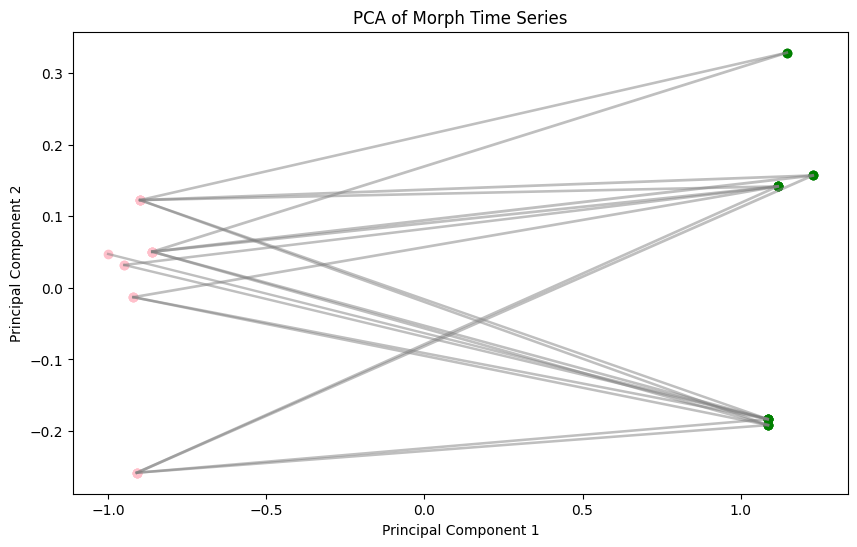

In [43]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Combine both classes for PCA fitting
combined_data = np.vstack([
    morph.class0_X.reshape(morph.class0_X.shape[0], -1),
    morph.class1_X.reshape(morph.class1_X.shape[0], -1)
])

# Fit PCA on combined data
pca = PCA(n_components=3)
pca.fit(combined_data)

# Transform each class
pca_c0 = pca.transform(morph.class0_X.reshape(morph.class0_X.shape[0], -1))
pca_c1 = pca.transform(morph.class1_X.reshape(morph.class1_X.shape[0], -1))

# Plotting
plt.figure(figsize=(10, 6))

# Plot the pair
for pair in morph.borderline_pairs.keys():
    # Plot the points
    plt.scatter(pca_c0[pair[0], 0], pca_c0[pair[0], 1], 
               color='green', marker='o')
    plt.scatter(pca_c1[pair[1], 0], pca_c1[pair[1], 1], 
               color='pink', marker='o')
    
    # Plot the connection between pair
    plt.plot([pca_c0[pair[0], 0], pca_c1[pair[1], 0]], 
             [pca_c0[pair[0], 1], pca_c1[pair[1], 1]], 
             'gray', alpha=0.5, linewidth=res[2][pair] * 4)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Morph Time Series")
plt.show()

In [ ]:
# apply PCA to the morphs
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(res[0])